In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
df = pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates=True)

In [3]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [4]:
## Frequence is None .. Now we have to set AS MS as month end frequency
## https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

In [5]:
df.index.freq = 'MS'

In [6]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

In [7]:
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [8]:
df.tail()

,Thousands of Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Freq: MS
Data columns (total 1 columns):
Thousands of Passengers    144 non-null int64
dtypes: int64(1)
memory usage: 2.2 KB


In [10]:
train_data = df.iloc[:109]
test_data = df.iloc[108:]

## Simple Exponential Moving Average

In [11]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

span = 12
alpha = 2/(span+1)

df['EWMA12'] = df['Thousands of Passengers'].ewm(alpha=alpha,adjust=False).mean()
df['SES12']=SimpleExpSmoothing(df['Thousands of Passengers']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)
df.head()

,Thousands of Passengers,EWMA12,SES12
Month,,,
1949-01-01,112,112.000000,112.000000
1949-02-01,118,112.923077,112.923077
1949-03-01,132,115.857988,115.857988
1949-04-01,129,117.879836,117.879836
1949-05-01,121,118.359861,118.359861


## Double Exponential Smoothing

In [12]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [13]:
df['DESadd12'] = ExponentialSmoothing(df['Thousands of Passengers'], trend='add').fit().fittedvalues.shift(-1)
df.head()

,Thousands of Passengers,EWMA12,SES12,DESadd12
Month,,,,
1949-01-01,112,112.000000,112.000000,114.237762
1949-02-01,118,112.923077,112.923077,120.237762
1949-03-01,132,115.857988,115.857988,134.237762
1949-04-01,129,117.879836,117.879836,131.237762
1949-05-01,121,118.359861,118.359861,123.237762


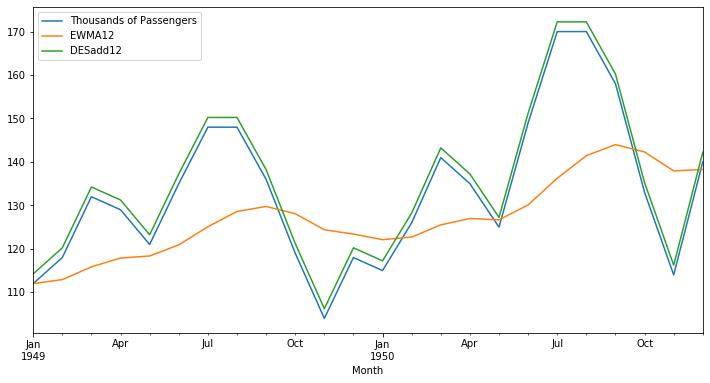

In [14]:

df[['Thousands of Passengers','EWMA12','DESadd12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

#### Here we can see that Double Exponential Smoothing is a much better representation of the time series data.
#### Let's see if using a multiplicative seasonal adjustment helps.

In [15]:
df['DESmul12'] = ExponentialSmoothing(df['Thousands of Passengers'], trend='mul').fit().fittedvalues.shift(-1)
df.head()

,Thousands of Passengers,EWMA12,SES12,DESadd12,DESmul12
Month,,,,,
1949-01-01,112,112.000000,112.000000,114.237762,112.049247
1949-02-01,118,112.923077,112.923077,120.237762,118.051885
1949-03-01,132,115.857988,115.857988,134.237762,132.058041
1949-04-01,129,117.879836,117.879836,131.237762,129.056722
1949-05-01,121,118.359861,118.359861,123.237762,121.053204


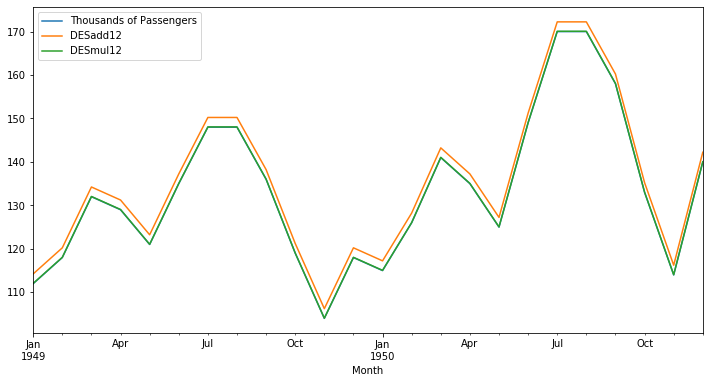

In [16]:

df[['Thousands of Passengers','DESadd12','DESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

#### Although minor, it does appear that a multiplicative adjustment gives better results. Note that the green line almost completely overlaps the original data.

## Triple Exponential Smoothing

#### Triple Exponential Smoothing, the method most closely associated with Holt-Winters, adds support for both trends and seasonality in the data.

In [17]:
df['TESadd12'] = ExponentialSmoothing(df['Thousands of Passengers'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
df.head()

C:\Users\z023208\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


,Thousands of Passengers,EWMA12,SES12,DESadd12,DESmul12,TESadd12
Month,,,,,,
1949-01-01,112,112.000000,112.000000,114.237762,112.049247,113.081288
1949-02-01,118,112.923077,112.923077,120.237762,118.051885,120.550753
1949-03-01,132,115.857988,115.857988,134.237762,132.058041,135.527339
1949-04-01,129,117.879836,117.879836,131.237762,129.056722,133.155076
1949-05-01,121,118.359861,118.359861,123.237762,121.053204,125.656129


In [18]:
df['TESmul12'] = ExponentialSmoothing(df['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
df.head()

,Thousands of Passengers,EWMA12,SES12,DESadd12,DESmul12,TESadd12,TESmul12
Month,,,,,,,
1949-01-01,112,112.000000,112.000000,114.237762,112.049247,113.081288,111.608110
1949-02-01,118,112.923077,112.923077,120.237762,118.051885,120.550753,118.853687
1949-03-01,132,115.857988,115.857988,134.237762,132.058041,135.527339,133.343675
1949-04-01,129,117.879836,117.879836,131.237762,129.056722,133.155076,127.912641
1949-05-01,121,118.359861,118.359861,123.237762,121.053204,125.656129,120.991626


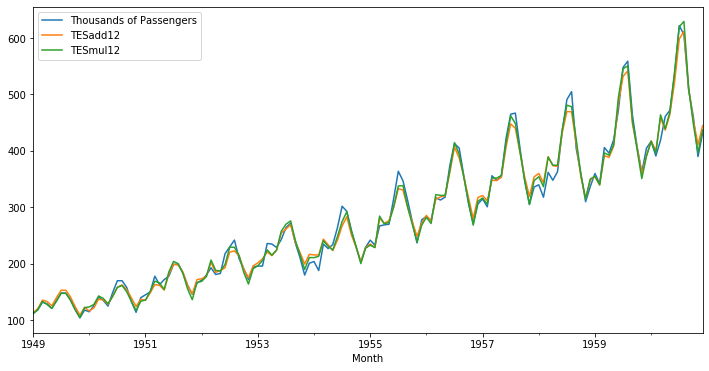

In [19]:
df[['Thousands of Passengers','TESadd12','TESmul12']].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

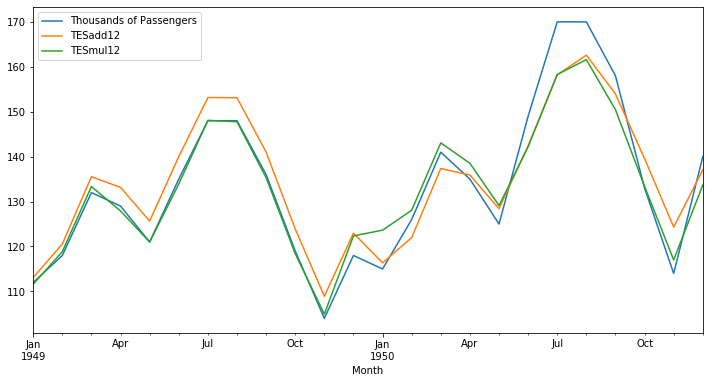

In [20]:
df[['Thousands of Passengers','TESadd12','TESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

#### Based on the plot above, you might think that Triple Exponential Smoothing does a poorer job of fitting than Double Exponential Smoothing. The key here is to consider what comes next - forecasting. We'll see that having the ability to predict fluctuating seasonal patterns greatly improves our forecast.

In [21]:
model=ExponentialSmoothing(train_data['Thousands of Passengers'],trend='mul',seasonal = 'mul',seasonal_periods=12)

In [22]:
fitted_model=model.fit()

In [23]:
test_prediction=fitted_model.forecast(36)

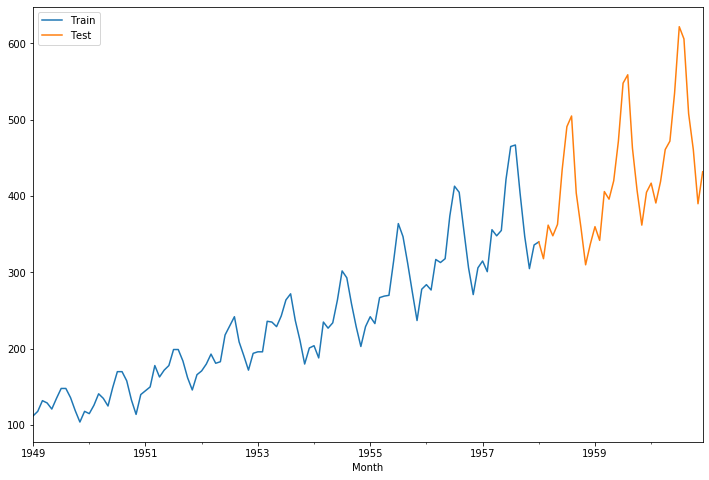

In [24]:
train_data['Thousands of Passengers'].plot(legend=True,label = "Train",figsize=(12,8))
test_data['Thousands of Passengers'].plot(legend=True,label = "Test",figsize=(12,8))

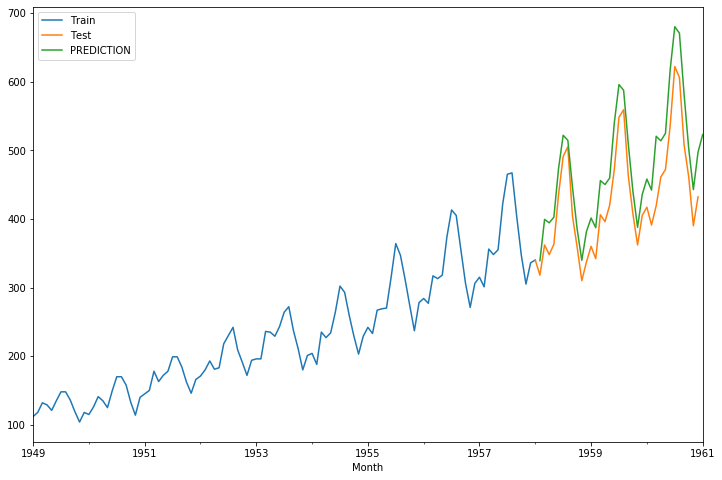

In [25]:
train_data['Thousands of Passengers'].plot(legend=True,label = "Train",figsize=(12,8))
test_data['Thousands of Passengers'].plot(legend=True,label = "Test",figsize=(12,8))
test_prediction.plot(legend=True,label='PREDICTION')

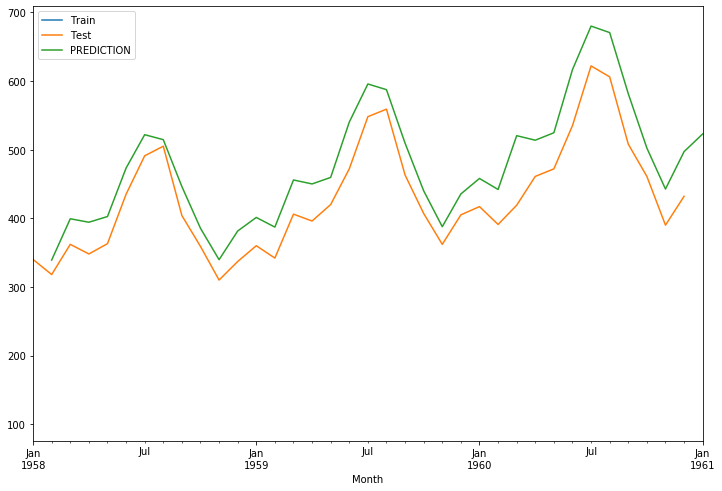

In [26]:
train_data['Thousands of Passengers'].plot(legend=True,label = "Train",figsize=(12,8))
test_data['Thousands of Passengers'].plot(legend=True,label = "Test",figsize=(12,8))
test_prediction.plot(legend=True,label='PREDICTION',xlim=['1958-01-01','1961-01-01'])

In [27]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [28]:
mean_absolute_error(test_data,test_prediction)

63.0282862810754

In [29]:
mean_squared_error(test_data,test_prediction)

5613.837862455122

In [30]:
np.sqrt(mean_squared_error(test_data,test_prediction))

74.92554879648945

In [31]:
final_model = ExponentialSmoothing(df['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit()

In [32]:
forcecast_prediction=final_model.forecast(36)

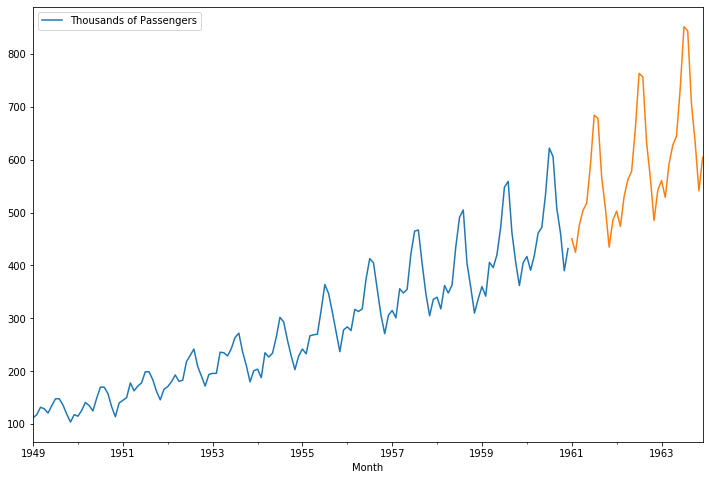

In [33]:
df['Thousands of Passengers'].plot(legend=True,figsize=(12,8))
forcecast_prediction.plot()